Load packages

In [2]:
import keras
print(keras.__version__)

import tensorflow as tf
print(tf.__version__)

import pandas as pd
print(pd.__version__)

import numpy as np
print(np.__version__)

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

2.1.4
1.6.0
0.22.0
1.14.1


Pretty plotting

In [3]:
# Use seaborn graphical settings, which are much prettier
sns.set()
# Scale widths, fonts, etc. to fit well in a paper (an alternative would be "notebook")
sns.set_context('notebook')
sns.set_style('whitegrid')

Load data and print some summaries.

In [4]:
import os
data_dir = '/Users/johannes/OneDrive/Master Thesis - ML/03 - Programming/R/Data_Preparation/data_wide'
fpath = os.path.join(data_dir, 'merged_wide.csv')

df = pd.read_csv(fpath, sep = ",", header = 0, index_col = 0, 
                 parse_dates = True, infer_datetime_format = True)

headers = list(df)

print(df.get_dtype_counts())
print(df.shape)

# Convert to numpy ndarray
dfn = df.as_matrix()

df.head(3)

float64    185
int64       80
dtype: int64
(53400, 265)


,Win_VWP_Near,DeliveryHour,DeliveryMonth,DeliveryWeekday,Reg_DD_DK1,Reg_DD_DK2,Reg_DD_FI,Reg_DD_NO1,Reg_DD_NO2,Reg_DD_NO3,...,miss_Cap_DK1A_SE3,miss_Cap_SE3_DK1A,miss_Cap_DK1A_NO2,miss_Cap_NO2_DK1A,miss_Op_CE_SE1,miss_Op_CE_SE2,miss_Op_CE_SE3,miss_Op_CE_SE4,miss_Win_VWP_Near_Lag,miss_Win_Volume_Near_Lag
DeliveryTime,,,,,,,,,,,,,,,,,,,,,
2011-11-02 01:00:00,35.975,1,11,4,1,1,-1,0,0,0,...,1,1,0,0,1,1,0,0,0,0
2011-11-02 02:00:00,34.448,2,11,4,-1,1,-1,-1,-1,-1,...,1,1,0,0,1,1,0,0,0,0
2011-11-02 03:00:00,35.313,3,11,4,-1,0,-1,-1,-1,-1,...,1,1,0,0,1,1,0,0,0,0


One-hot-encode categorical features using pandas, then standardize numerical features (not including the one-hot-encoded indicator variables) so each numerical feature has mean 0 and standard deviation 1.

In [5]:
# INSTEAD USING PANDAS DIRECTLY
# One-hot-encode categoricals
df2 = pd.get_dummies(df, columns = ["DeliveryHour", "DeliveryMonth", "DeliveryWeekday",
                                   "Reg_DD_DK1", "Reg_DD_DK2", "Reg_DD_FI", "Reg_DD_NO1",
                                   "Reg_DD_NO2", "Reg_DD_NO3", "Reg_DD_NO4", "Reg_DD_NO5",
                                   "Reg_DD_SE1", "Reg_DD_SE2", "Reg_DD_SE3", "Reg_DD_SE4"])

headers = list(df2)

# Define dataset sizes
## 1 year = 365*24 = 8,760
valid_size = 8760
test_size = 8760
train_size = df2.shape[0] - valid_size - test_size

# Convert pandas DataFrame to Numpy ndarray
df2n = df2.as_matrix()

# Last column to normalize
## All columns to the right are binary missing-flags or one-hot-encoded, so don't standardize
ind_last = list(df2).index('UMM_CE_Cnt')

means_num = np.nanmean(df2n[:train_size, :ind_last], axis = 0)
stdevs_num = np.nanstd(df2n[:train_size, :ind_last], axis = 0)
    
# Pad mean with 0's and st. dev. with 1's for indicators and one-hots
## To avoid standardizing these variables
means = np.concatenate([means_num, np.repeat(0, df2n.shape[1] - ind_last)])
stdevs = np.concatenate([stdevs_num, np.repeat(1, df2n.shape[1] - ind_last)])

# Standardize
df2n -= means
df2n /= stdevs

# Replace NaNs with 0's
print("NaNs imputed with 0's:", np.isnan(df2n).sum())
df2n = np.nan_to_num(df2n)

df2n_train = df2n[:-(valid_size+test_size)]
df2n_valid = df2n[-(valid_size+test_size):-test_size]
df2n_test = df2n[-test_size:]

# Save datasets to files so they can be imported elsewhere
np.savetxt('Data/standardized_complete.csv', df2n, delimiter = ",", header = ','.join(headers), comments = '')
np.savetxt('Data/standardized_train.csv', df2n_train, delimiter = ",", header = ','.join(headers), comments = '')
np.savetxt('Data/standardized_valid.csv', df2n_valid, delimiter = ",", header = ','.join(headers), comments = '')
np.savetxt('Data/standardized_test.csv', df2n_test, delimiter = ",", header = ','.join(headers), comments = '')

# Save helper data
pickle.dump(means, open('Data/means', 'wb'))
pickle.dump(stdevs, open('Data/stdevs', 'wb'))
pickle.dump(headers, open('Data/headers', 'wb'))

NaNs imputed with 0's: 34364


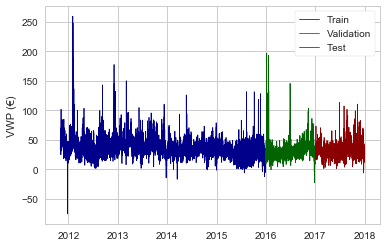

In [6]:
plt.figure()
plt.plot(df2["Win_VWP_Near"][:train_size], linewidth = 0.75, color = "darkblue")
plt.plot(df2["Win_VWP_Near"][train_size:-test_size], linewidth = 0.75, color = "darkgreen")
plt.plot(df2["Win_VWP_Near"][-test_size:], linewidth = 0.75, color = "darkred")
plt.legend(('Train', 'Validation', 'Test'), frameon = True, framealpha = 1)
plt.ylabel("VWP (€)")
plt.savefig("dataset_split.pdf")
plt.show()

## Common sense baselines: Validation
Mean Absolute Error (MAE) on the validation data for an apples-to-apples comparison. 

First, unstandardize the dataset:

In [7]:
df2n_unstd = np.copy(df2n)

df2n_unstd *= stdevs
df2n_unstd += means

targets = df2n_unstd[train_size:-test_size, headers.index("Win_VWP_Near")]

#### Predicting mean VWP from training set

In [8]:
print("MAE  €", round(np.mean(np.abs(targets - means[0])), 5))
print("RMSE €", round(np.sqrt(np.mean(np.square(targets - means[0]))), 5))

MAE  € 9.00181
RMSE € 12.60574


#### Predicting system price of corresponding DeliveryHour

In [9]:
preds = df2n_unstd[train_size:-test_size, headers.index("Spot_PR_SP1")]
print("MAE  €", round(np.mean(np.abs(targets - preds)), 5))
print("RMSE €", round(np.sqrt(np.mean(np.square(targets - preds))), 5))

MAE  € 4.14593
RMSE € 7.53903


#### Predicting 6-hour lagged VWP (DeliveryHour 6 hours prior)
Assumed to represent the latest available information at the time of prediction.

In [10]:
preds = df2n_unstd[(train_size-6):-(test_size+6), headers.index("Win_VWP_Near")]
print("MAE  €", round(np.mean(np.abs(targets - preds)), 5))
print("RMSE €", round(np.sqrt(np.mean(np.square(targets - preds))), 5))

MAE  € 7.25657
RMSE € 12.27183


#### Predicting VWP of corresponding DeliveryHour of previous day

In [11]:
preds = df2n_unstd[(train_size-24):-(test_size+24), headers.index("Win_VWP_Near")]
print("MAE  €", round(np.mean(np.abs(targets - preds)), 5))
print("RMSE €", round(np.sqrt(np.mean(np.square(targets - preds))), 5))

MAE  € 5.31672
RMSE € 10.19886


#### Predicting SE3 price of corresponding DeliveryHour

In [12]:
preds = df2n_unstd[train_size:-test_size, headers.index("Spot_PR_SE3")]
print("MAE  €", round(np.mean(np.abs(targets - preds)), 5))
print("RMSE €", round(np.sqrt(np.mean(np.square(targets - preds))), 5))

MAE  € 2.95553
RMSE € 5.93879


#### Predicting "far" VWP of corresponding DeliveryHour

In [13]:
preds = df2n_unstd[train_size:-test_size, headers.index("Win_VWP_Far")]
print("MAE  €", round(np.mean(np.abs(targets - preds)), 5))
print("RMSE €", round(np.sqrt(np.mean(np.square(targets - preds))), 5))

MAE  € 4.80941
RMSE € 7.58732


## Common sense baselines: Test
Mean Absolute Error (MAE) on the test data for an apples-to-apples comparison of final model performance estimates. 

First, unstandardize the dataset:

In [16]:
targets = df2n_unstd[-test_size:, headers.index("Win_VWP_Near")]

#### Predicting mean VWP from training set

In [17]:
print("MAE  €", round(np.mean(np.abs(targets - means[0])), 5))
print("RMSE €", round(np.sqrt(np.mean(np.square(targets - means[0]))), 5))

MAE  € 6.68287
RMSE € 9.26446


#### Predicting system price of corresponding DeliveryHour

In [18]:
preds = df2n_unstd[-test_size:, headers.index("Spot_PR_SP1")]
print("MAE  €", round(np.mean(np.abs(targets - preds)), 5))
print("RMSE €", round(np.sqrt(np.mean(np.square(targets - preds))), 5))

MAE  € 4.46757
RMSE € 7.0356


#### Predicting 6-hour lagged VWP (DeliveryHour 6 hours prior)
Assumed to represent the latest available information at the time of prediction.

In [19]:
preds = df2n_unstd[-test_size-6:-6, headers.index("Win_VWP_Near")]
print("MAE  €", round(np.mean(np.abs(targets - preds)), 5))
print("RMSE €", round(np.sqrt(np.mean(np.square(targets - preds))), 5))

MAE  € 7.16691
RMSE € 10.27575


#### Predicting VWP of corresponding DeliveryHour of previous day

In [20]:
preds = df2n_unstd[-test_size-24:-24, headers.index("Win_VWP_Near")]
print("MAE  €", round(np.mean(np.abs(targets - preds)), 5))
print("RMSE €", round(np.sqrt(np.mean(np.square(targets - preds))), 5))

MAE  € 6.02676
RMSE € 9.02005


#### Predicting SE3 price of corresponding DeliveryHour

In [21]:
preds = df2n_unstd[-test_size:, headers.index("Spot_PR_SE3")]
print("MAE  €", round(np.mean(np.abs(targets - preds)), 5))
print("RMSE €", round(np.sqrt(np.mean(np.square(targets - preds))), 5))

MAE  € 3.42779
RMSE € 5.64666


#### Predicting "far" VWP of corresponding DeliveryHour

In [22]:
preds = df2n_unstd[-test_size:, headers.index("Win_VWP_Far")]
print("MAE  €", round(np.mean(np.abs(targets - preds)), 5))
print("RMSE €", round(np.sqrt(np.mean(np.square(targets - preds))), 5))

MAE  € 4.00376
RMSE € 6.20141
